In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
def setDefaultParams():
    params = {}
    params["alpha"] = 10 ** 13.6       # Large path loss exponent
    params["beta"] = 3.6               # Path loss exponent
    params["G"] = 10 ** 0.3            # Antenna gain
    params["L"] = 10 ** 0.7            # Losses
    params["PRBsize"] = 180000         # 180 kHz
    params["noise_dB"] = -174 + 10 * np.log10(params["PRBsize"]) + 6  # +6 dB for NoiseRise
    params["bruit"] = 10 ** (params["noise_dB"] / 10) / 1000           # Noise + interference in watts
    params["Pmax"] = 0.5               # Maximum power
    
    # Set 2
    params["packet_size_bits"] = 100 * 8   # 0.1 KB in bits
    params["slot_length"] = 0.001          # 1 ms
    params["K"] = params["packet_size_bits"] / (params["PRBsize"]* params["slot_length"])  # Transmission efficiency factor
    params["a"] = 0.5
    params["E_max"] = 6      # dB
    params["E_min"] = 0.01  # dB
    params["lambda_"] = 1 / 2  # Parameter of the fast fading exponential distributions

    return params

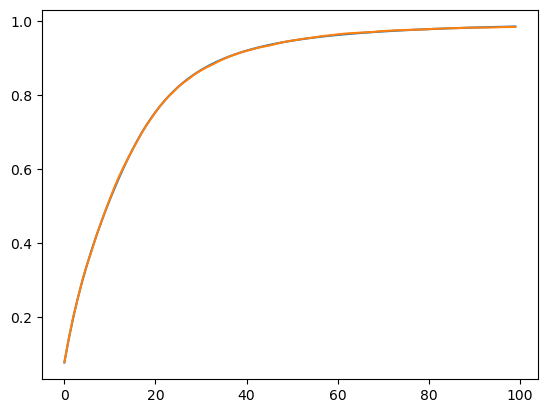

In [32]:
import numpy as np

# ----------------- helpers -----------------
def c_of_d(d, p):
    return (p["G"]*p["Pmax"]) / (p["alpha"] * d**p["beta"] * p["L"] * p["bruit"])

def rho_bounds(p):
    return p["K"]/(p["a"]*p["E_max"]), p["K"]/(p["a"]*p["E_min"])

def h_of_r(r, d, p):
    # r: (m,1), d: (1,n) -> (m,n)
    return (2.0**(p["K"]/(p["a"]*r)) - 1.0) / c_of_d(d, p)

def analytic_cdf_one_packet_rayleigh(r_vals, p, R, n_d=4000):
    """
    F_rho(r) = ∫_0^R P(rho <= r | d) * (2d/R^2) dd, with Rayleigh(sigma) fading.
    Uses trapezoidal rule over d for proper normalization.
    """
    r_vals = np.atleast_1d(r_vals).astype(float)
    under, over = rho_bounds(p)

    # distance grid on (0,R]; avoid d=0
    d = np.linspace(0.0, R, n_d+1)[1:]
    w = 2.0 * d / (R**2)                         # p_D(d) = 2d/R^2

    # conditional interior CDF for Rayleigh: exp( - h(r;d)^2 / (2 sigma^2) )
    H = h_of_r(r_vals[:, None], d[None, :], p)   # (m,n_d)
    F_cond = np.exp( - (H**2) / (2.0 * p["sigma"]**2) )

    # clamp by rows (below underline -> 0, above overline -> 1)
    below = r_vals <= under
    above = r_vals >= over
    if np.any(below):
        F_cond[below, :] = 0.0
    if np.any(above):
        F_cond[above, :] = 1.0

    # Proper integral over d
    F = np.trapz(F_cond * w[None, :], d, axis=1)

    # numerical hygiene
    F = np.clip(F, 0.0, 1.0)
    return F

def pmf_from_integer_grid_cdf(F_on_grid):
    # P(N=n) = F(n) - F(n-1) assuming grid is consecutive integers
    diff = F_on_grid[1:] - F_on_grid[:-1]
    return np.clip(diff, 0.0, 1.0)

# ----------------- Monte Carlo (1 packet, Rayleigh) -----------------
def mc_one_packet_rayleigh(p, R=1.0, K=300_000, seed=1):
    rng = np.random.default_rng(seed)
    # d ~ area-uniform in disk
    d = R * np.sqrt(rng.random(K))
    cD = c_of_d(d, p)
    # F ~ Rayleigh(sigma): F = sigma * sqrt(-2 ln U)
    U = rng.random(K)
    F = p["sigma"] * np.sqrt(-2.0 * np.log(1.0 - U))
    SINR = cD * F
    core = np.log2(1.0 + SINR)
    core = np.clip(core, p["E_min"], p["E_max"])
    E = p["a"] * core
    rho = p["K"] / E
    Nrb = np.ceil(rho).astype(int)
    vals, counts = np.unique(Nrb, return_counts=True)
    pmf = counts / counts.sum()
    return vals, pmf, rho

# ----------------- Compare analytic vs MC on integers -----------------
# ----------------- params (same structure as yours) -----------------
def compare_analytic_vs_mc_on_integers(sigma, K=10_000, R = 1.0):
    params = setDefaultParams()
    params["sigma"] = sigma

    vals_mc, pmf_mc, _ = mc_one_packet_rayleigh(params, R=R, K=K, seed=None)

    under, over = rho_bounds(params)
    n_min = max(1, int(np.floor(under)) - 2)
    n_max = int(np.ceil(over)) + 2
    grid_int = np.arange(n_min, n_max + 1)

    F_grid = analytic_cdf_one_packet_rayleigh(grid_int, params, R)
    pmf_an = pmf_from_integer_grid_cdf(F_grid)

    cdf_mc = np.cumsum(pmf_mc)
    cdf_an = np.cumsum(pmf_an)
    return cdf_mc, cdf_an

# Compare multiple sigma values
sigma_values = [0.1, 0.3, 0.5, 0.9]
colors = ['blue', 'red', 'green', 'purple']

plt.figure(figsize=(12, 8))

for i, sigma in enumerate(sigma_values):
    cdf_mc, cdf_an = compare_analytic_vs_mc_on_integers(sigma, K=10000)
    
    # Plot analytical and MC results
    plt.plot(cdf_an[:100], color=colors[i], linestyle='-', linewidth=2, 
             label=f'Analytical σ={sigma}')
    plt.plot(cdf_mc[:100], color=colors[i], linestyle='--', linewidth=1.5, 
             alpha=0.8, label=f'Monte Carlo σ={sigma}')

plt.xlabel('Nrb')
plt.ylabel('Cumulative Probability')
plt.title('Comparison of Analytical vs Monte Carlo Results for Different σ Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
